In [47]:
import collections
import matplotlib.pyplot as plt
from IPython import display
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from common.ffn.ffn_relu import ParametricReLUNet
from common.ffn.ffn_base import FFNGmetricLogging
from util import *

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid


#### MNIST dataset

MNIST dataset is used which contains 60000 28x28 images of handwritten digits from 0 to 9. 

In [48]:
# use it to conver from PIL to torch.Tensor
image_transform = ToTensor()

train_dataset = MNIST(root='./', train=True, download=True, transform=image_transform)
test_dataset = MNIST(root='./', train=False, download=True, transform=image_transform)

In [49]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
)

Data example:

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])
Labels: [[0, 8, 5, 3, 0, 8, 2, 3], [0, 6, 5, 7, 6, 8, 0, 6], [6, 0, 1, 8, 7, 1, 5, 7], [3, 1, 8, 9, 0, 9, 9, 4]]


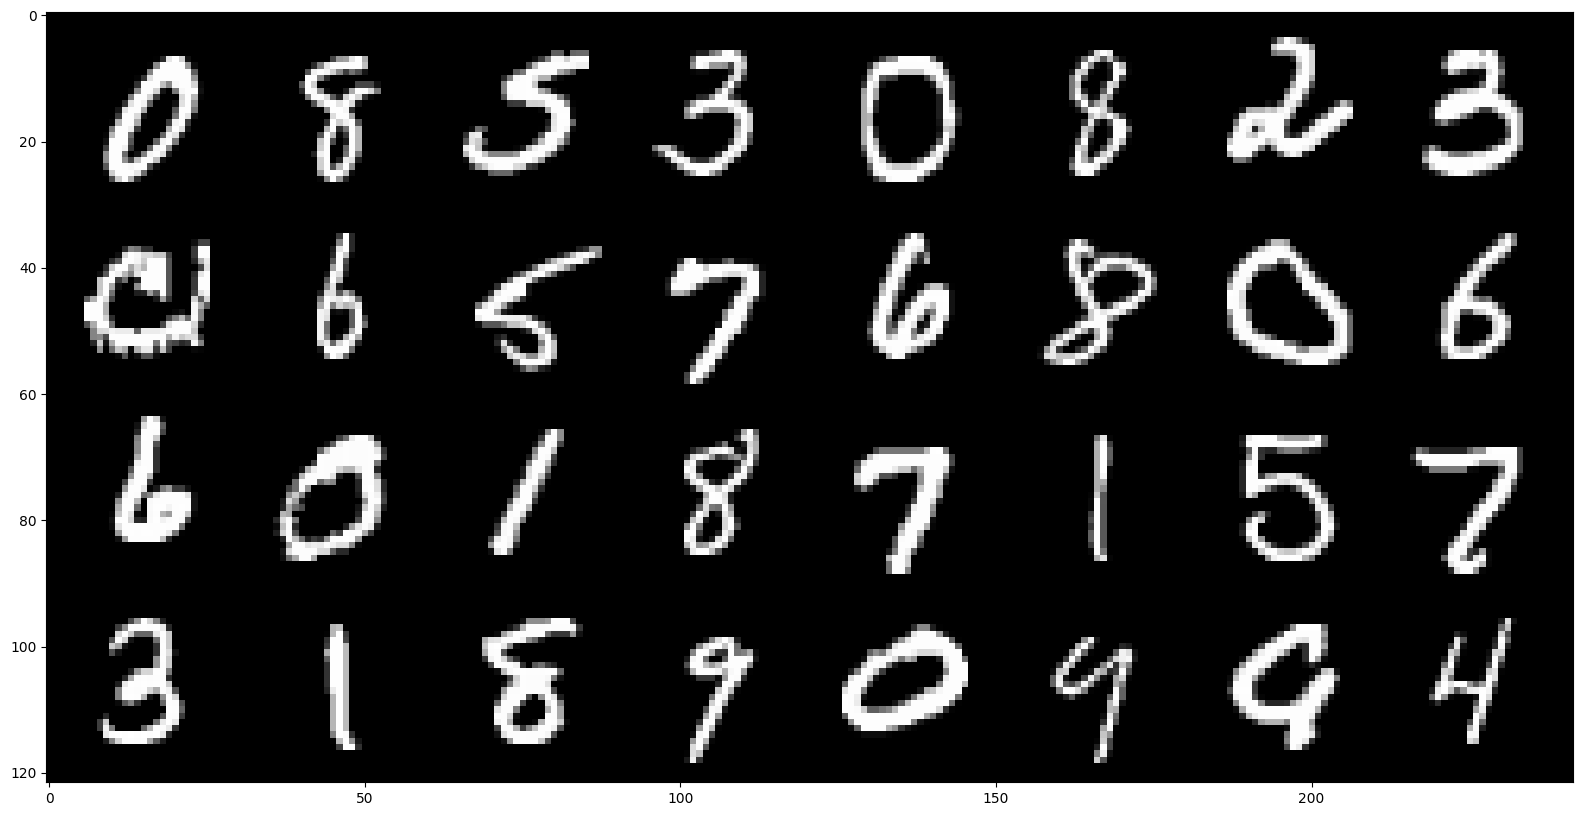

In [50]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
#img = train_features[0].squeeze()
images = make_grid(train_features, 8).permute(1, 2, 0)
labels = train_labels.view(-1, 8).tolist()
print(f"Labels: {labels}")
plt.figure(figsize=(20, 10))
plt.imshow(images, cmap="gray")
plt.show()


#### FFN as a reference implementation

Typical implementation of image-recognition

FFN with 2 hidden layers: 
- nn.ReLU is an activation-function
- nn.Sequential is used to combine several layers into one model 

In [51]:
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
                
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)
        
    def forward(self, x):
        #x = [batch size, height, width]
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        #x = [batch size, height * width]
        h_1 = F.relu(self.input_fc(x))
        #h_1 = [batch size, 250]
        h_2 = F.relu(self.hidden_fc(h_1))
        #h_2 = [batch size, 100]
        y_pred = self.output_fc(h_2)
        #y_pred = [batch size, output dim]
        return y_pred, h_2


INPUT_DIM = 28 * 28
OUTPUT_DIM = 10  # num classes
H1, H2 = 250, 100

# HINT
# Use nn.Sequential, nn.Linear and nn.ReLU

### YOUR SOLUTION ###
model2 = MLP(INPUT_DIM, OUTPUT_DIM)

Cross-entropy loss and stochastic gradient descent optimiser are used. Descent is performed in number of epochs, no stop-criterion for gradient descent. Accuracy is a metric for the learninng process.

#### Experiment with FFN in non-criticality mode

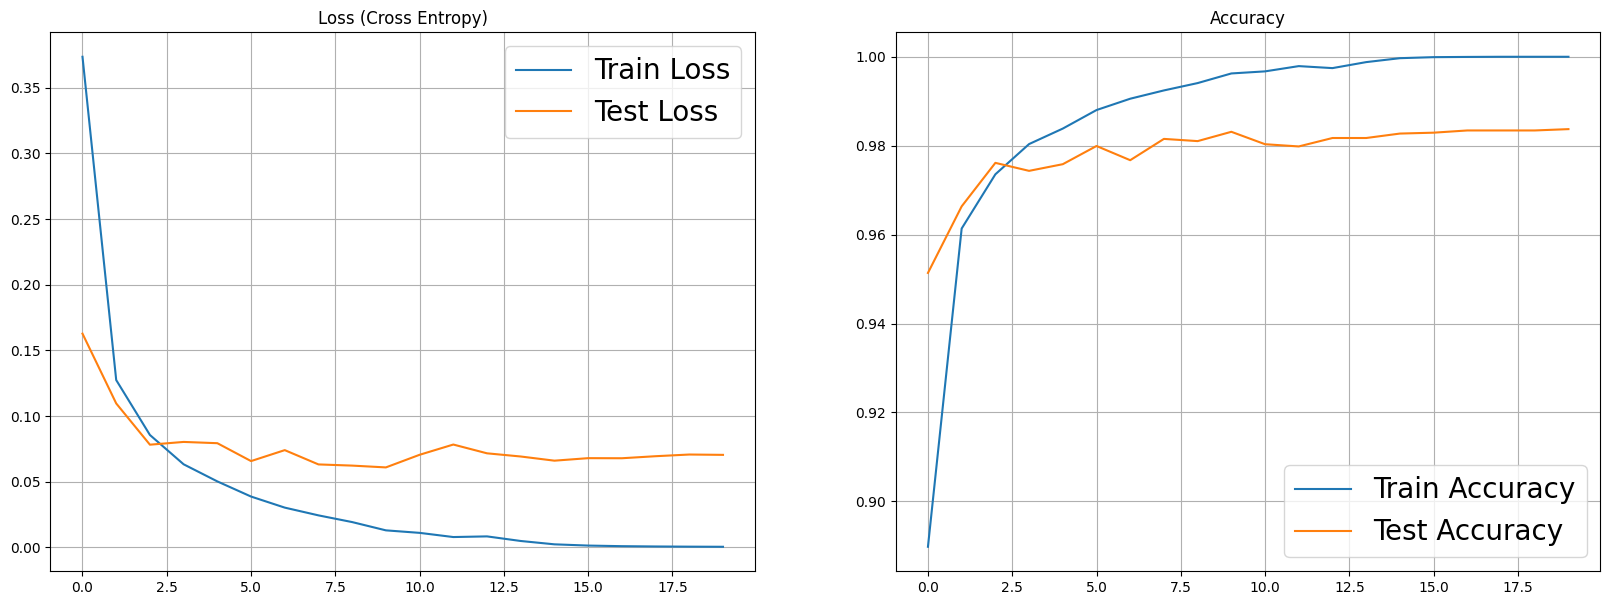

In [52]:
NUM_EPOCH = 20
HISTORY_NONCRITICALITY = collections.defaultdict(list)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=1e-2, momentum=0.9, nesterov=True)

DEVICE = torch.device('cpu')  # you can change to `cuda:0`
model2.to(DEVICE)

for epoch in range(NUM_EPOCH):
    # AverageMeter will accumulate average of some metric
    # Procceed to `utils.py` to see implementation
    train_loss_meter = AverageMeter()
    train_accuracy_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    test_accuracy_meter = AverageMeter()
    
    # training loop
    for train_batch in train_dataloader:
        
        # unpack batch and move to specific device (for example, GPU or TPU)
        images, labels = train_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        logits, _ = model2.forward(images)
        prediction = logits.argmax(dim=-1)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # calculate current average loss and accuracy
        train_loss_meter.update(loss.item())
        train_accuracy_meter.update(
            calculate_accuracy(
                prediction.detach(),
                labels
            ).item()
        )
    #break
    # save average train loss and accuracy
    HISTORY_NONCRITICALITY['train_loss'].append(train_loss_meter.avg)
    HISTORY_NONCRITICALITY['train_accuracy'].append(train_accuracy_meter.avg)
        
    # testing loop
    for test_batch in test_dataloader:
        images, labels = test_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # аdd `with torch.no_grad()' to avoid computing gradients of weights
        with torch.no_grad():
            # do everything like we did in training loop
            logits, _ = model2(images)
            prediction = logits.argmax(dim=-1)
            loss = criterion(logits, labels)
        
        test_loss_meter.update(loss.item())
        test_accuracy_meter.update(
            calculate_accuracy(
                prediction,
                labels
            ).item()
        )
    
    # save average test accuracy loss and accuracy
    HISTORY_NONCRITICALITY['test_loss'].append(test_loss_meter.avg)
    HISTORY_NONCRITICALITY['test_accuracy'].append(test_accuracy_meter.avg)
    
    # visualize all together
    display.clear_output()
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    axes[0].set_title('Loss (Cross Entropy)')
    axes[0].plot(HISTORY_NONCRITICALITY['train_loss'], label='Train Loss')
    axes[0].plot(HISTORY_NONCRITICALITY['test_loss'], label='Test Loss')
    axes[0].grid()
    axes[0].legend(fontsize=20)
    
    axes[1].set_title('Accuracy')
    axes[1].plot(HISTORY_NONCRITICALITY['train_accuracy'], label='Train Accuracy')
    axes[1].plot(HISTORY_NONCRITICALITY['test_accuracy'], label='Test Accuracy')
    axes[1].grid()
    axes[1].legend(fontsize=20)
    
    plt.show()

In [53]:
print("Accuracy achieved in non-criticality FFN: "+str(HISTORY_NONCRITICALITY['test_accuracy'][-1]))

Accuracy achieved in non-criticality FFN: 0.9837260383386581


The same experiment is with the network at Relu-criticality; positive and negative relu slopes are 1 and 0

In [54]:
class MNISTReLU(ParametricReLUNet):
    def __init__(self, input_dim, output_dim):
        super().__init__(n0=input_dim,nk=0,nl=output_dim,l=0, bias_on=True)
                
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward_(self, x):
        return self.forward(x)

    def forward(self, x):
        #x = [batch size, height, width]
        #batch_size = x.shape[0]
        #x = x.view(batch_size, -1)
        #x = [batch size, height * width]
        h_1 = self.PReLU(self.input_fc(x))
        #h_1 = [batch size, 250]
        h_2 = self.PReLU(self.hidden_fc(h_1))
        #h_2 = [batch size, 100]
        y_pred = self.output_fc(h_2)
        #y_pred = [batch size, output dim]
        return y_pred
    
    def init_weights(self, cb=0.0, cw=1.0):
        if self.get_log_level() == "debug":
            print("FeedForwardNet weights initialisation with cb={}, cw={}".format(cb, cw))

        #Weight initialisation as in 2.19, 2.20
        self.cb, self.cw = cb, cw
        self.init_linear_weights(self.input_fc, self.bias_on, cb, cw/self.input_fc.in_features)
        self.init_linear_weights(self.hidden_fc, self.bias_on, cb, cw/self.hidden_fc.in_features)
        self.init_linear_weights(self.output_fc, self.bias_on, cb, cw/self.output_fc.in_features)


#### Experiment with FFN in criticality mode for relu

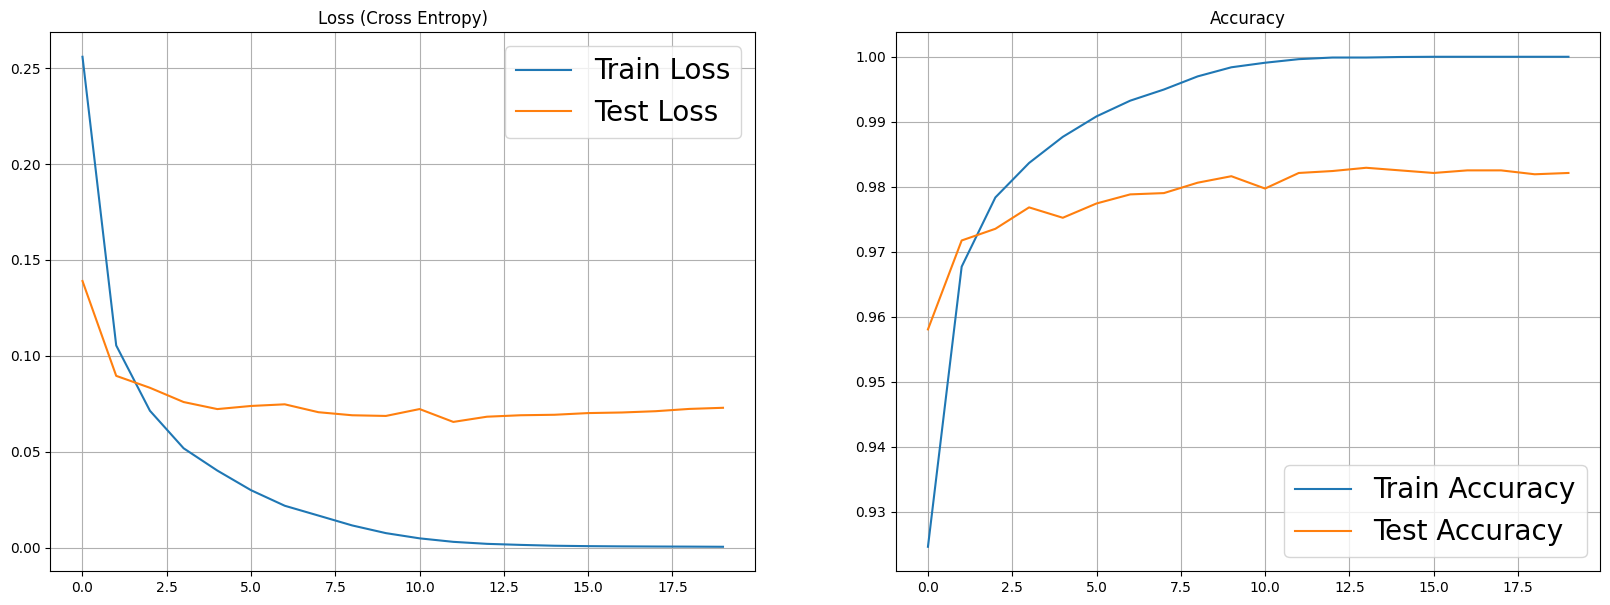

In [55]:
NUM_EPOCH = 20
HISTORY_CRITICALITY = collections.defaultdict(list)

INPUT_DIM = 28 * 28
OUTPUT_DIM = 10  # num classes

#Weights distribution variances are set as in (5.67)
slope_plus, slope_minus=1.0, 0.0
cb, cw = 0, 2.0/(slope_plus**2.0 + slope_minus**2.0)

testNet = MNISTReLU(INPUT_DIM, OUTPUT_DIM) #ParametricReLUNet(n0=INPUT_DIM,nk=250,nl=OUTPUT_DIM,l=2, bias_on=True)
testNet.set_log_level("info")
testNet.set_slopes(slope_plus, slope_minus)
testNet.init_weights(cb, cw)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(testNet.parameters(), lr=1e-2, momentum=0.9, nesterov=True)

DEVICE = torch.device('cpu')  # you can change to `cuda:0`
testNet.to(DEVICE)

for epoch in range(NUM_EPOCH):
    # AverageMeter will accumulate average of some metric
    # Procceed to `utils.py` to see implementation
    train_loss_meter, train_accuracy_meter, test_loss_meter, test_accuracy_meter = \
        AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()
    
    # training loop
    for train_batch in train_dataloader:
        
        # unpack batch and move to specific device (for example, GPU or TPU)
        images, labels = train_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        batch_size = images.shape[0]
        xx = images.view(batch_size, -1)
        logits = testNet.forward_(xx)
        prediction = logits.argmax(dim=-1)
        loss = criterion(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        #testNet.output_fc.backward()
        optimizer.step()

        # calculate current average loss and accuracy
        train_loss_meter.update(loss.item())
        train_accuracy_meter.update(
            calculate_accuracy(
                prediction.detach(),
                labels
            ).item()
        )
    #break
    # save average train loss and accuracy
    HISTORY_CRITICALITY['train_loss'].append(train_loss_meter.avg)
    HISTORY_CRITICALITY['train_accuracy'].append(train_accuracy_meter.avg)
        
    # testing loop
    for test_batch in test_dataloader:
        images, labels = test_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # аdd `with torch.no_grad()' to avoid computing gradients of weights
        with torch.no_grad():
            # do everything like we did in training loop
            batch_size = images.shape[0]
            xx = images.view(batch_size, -1)
            logits = testNet.forward_(xx)            
            prediction = logits.argmax(dim=-1)
            loss = criterion(logits, labels)
        
        test_loss_meter.update(loss.item())
        test_accuracy_meter.update(
            calculate_accuracy(
                prediction,
                labels
            ).item()
        )
    
    # save average test accuracy loss and accuracy
    HISTORY_CRITICALITY['test_loss'].append(test_loss_meter.avg)
    HISTORY_CRITICALITY['test_accuracy'].append(test_accuracy_meter.avg)
    
    # visualize all together
    display.clear_output()
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    axes[0].set_title('Loss (Cross Entropy)')
    axes[0].plot(HISTORY_CRITICALITY['train_loss'], label='Train Loss')
    axes[0].plot(HISTORY_CRITICALITY['test_loss'], label='Test Loss')
    axes[0].grid()
    axes[0].legend(fontsize=20)
    
    axes[1].set_title('Accuracy')
    axes[1].plot(HISTORY_CRITICALITY['train_accuracy'], label='Train Accuracy')
    axes[1].plot(HISTORY_CRITICALITY['test_accuracy'], label='Test Accuracy')
    axes[1].grid()
    axes[1].legend(fontsize=20)
    
    plt.show()

In [56]:
print("Accuracy achieved in FFN at Relu-criticality: "+str(HISTORY_CRITICALITY['test_accuracy'][-1]))

Accuracy achieved in FFN at Relu-criticality: 0.9821285942492013


The similar experiment is with the network at tanh-criticality

In [57]:
class MNISTTanh(FFNGmetricLogging):
    def __init__(self, input_dim, output_dim):
        super().__init__(n0=input_dim,nk=0,nl=output_dim,l=0, bias_on=True)
                
        self.input_fc = nn.Linear(input_dim, 250)
        self.hidden_fc = nn.Linear(250, 100)
        self.output_fc = nn.Linear(100, output_dim)

    def forward_(self, x):
        return self.forward(x)

    def forward(self, x):
        #x = [batch size, height, width]
        #batch_size = x.shape[0]
        #x = x.view(batch_size, -1)
        #x = [batch size, height * width]
        h_1 = torch.tanh(self.input_fc(x))
        #h_1 = [batch size, 250]
        h_2 = torch.tanh(self.hidden_fc(h_1))
        #h_2 = [batch size, 100]
        y_pred = self.output_fc(h_2)
        #y_pred = [batch size, output dim]
        return y_pred
    
    def init_weights(self, cb, cw1, cw2, cw3):
        if self.get_log_level() == "debug":
            print("FeedForwardNet weights initialisation with cb={}, cw1={}, cw2={}, cw3={}"\
                  .format(cb, cw1, cw2, cw3))

        #Weight initialisation as in 2.19, 2.20
        self.cb, self.cw = cb, cw
        self.init_linear_weights(self.input_fc, self.bias_on, cb, cw1/self.input_fc.in_features)
        self.init_linear_weights(self.hidden_fc, self.bias_on, cb, cw2/self.hidden_fc.in_features)
        self.init_linear_weights(self.output_fc, self.bias_on, cb, cw3/self.output_fc.in_features)


#### Experiment with FFN in tanh-criticality mode

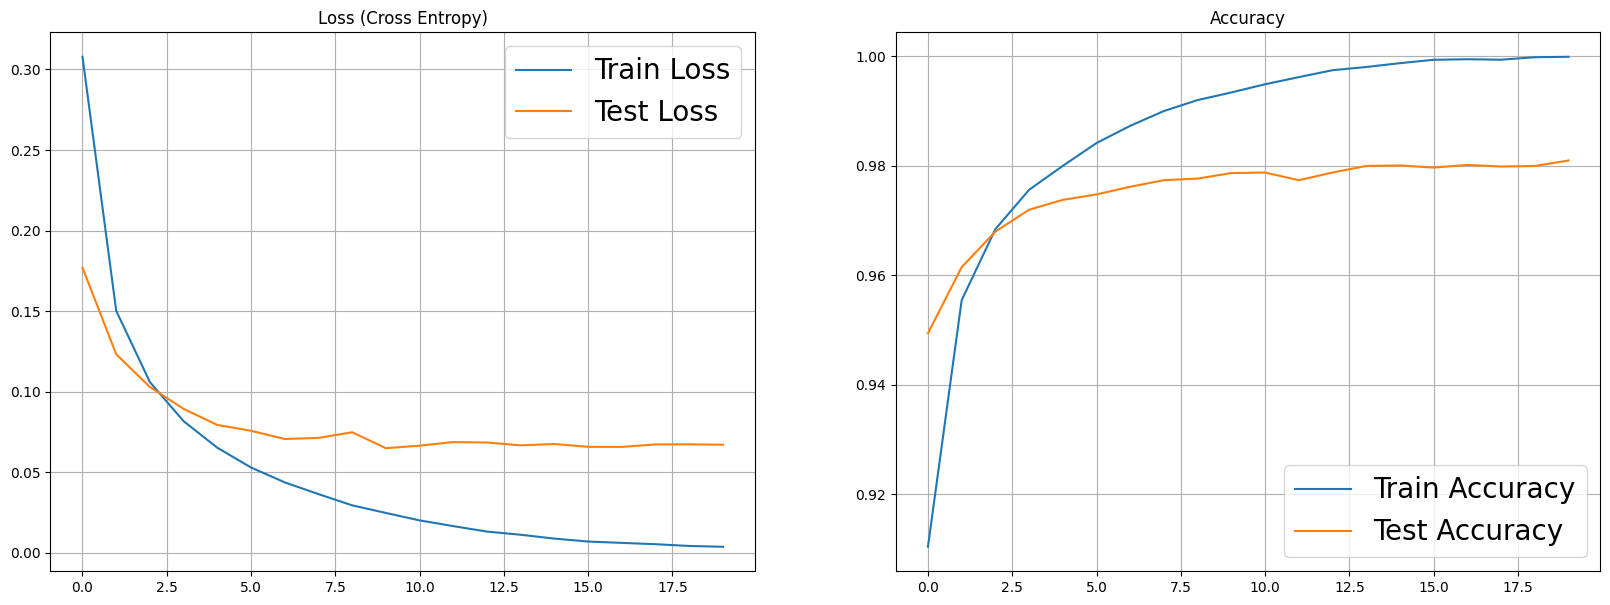

In [79]:
NUM_EPOCH = 20
HISTORY_CRITICALITY_TANH = collections.defaultdict(list)

INPUT_DIM = 28 * 28
OUTPUT_DIM = 10  # num classes

testNet = MNISTTanh(INPUT_DIM, OUTPUT_DIM)
testNet.set_log_level("info")

#weights distribution variances are set as in (5.139)+(5.142): σ_1=tanh'(0)=1, c^0_w=1/σ_1^2, 
#c^1_w=2/(3*σ_1^2), n_l=in_features
cb, cw1, cw2, cw3 = 0, 1.0 + (2.0/(testNet.input_fc.in_features*3.0)), \
    1.0 + (2.0/(testNet.hidden_fc.in_features*3.0)), 1.0 + (2.0/(testNet.output_fc.in_features*3.0))
testNet.init_weights(cb, cw1, cw2, cw3)

criterion = nn.CrossEntropyLoss()
#lambda - steps are set according to (9.70), given lambda_b^tilda=lambda_w^tilda=base_lr
base_lr = 1e-2
#optimizer = optim.SGD(testNet.parameters(), lr=1e-2, momentum=0.9, nesterov=True)
#TODO: divide base_lr by testNet.xxx_fc.in_features for weights?
optimizer = optim.SGD([{'params': testNet.input_fc.bias, 'lr': base_lr/1},\
                       {'params': testNet.hidden_fc.bias, 'lr': base_lr/2},\
                       {'params': testNet.output_fc.bias, 'lr': base_lr/3},\
                       {'params': testNet.input_fc.weight, 'lr': base_lr},\
                       {'params': testNet.hidden_fc.weight, 'lr': base_lr},\
                       {'params': testNet.output_fc.weight, 'lr': base_lr}
], lr=base_lr, momentum=0.9, nesterov=True)

DEVICE = torch.device('cpu')  # you can change to `cuda:0`
testNet.to(DEVICE)

for epoch in range(NUM_EPOCH):
    # AverageMeter will accumulate average of some metric
    # Procceed to `utils.py` to see implementation
    train_loss_meter, train_accuracy_meter, test_loss_meter, test_accuracy_meter = \
        AverageMeter(), AverageMeter(), AverageMeter(), AverageMeter()
    
    # training loop
    for train_batch in train_dataloader:
        
        # unpack batch and move to specific device (for example, GPU or TPU)
        images, labels = train_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        batch_size = images.shape[0]
        xx = images.view(batch_size, -1)
        logits = testNet.forward_(xx)
        prediction = logits.argmax(dim=-1)
        loss = criterion(logits, labels)
        
        optimizer.zero_grad()
        loss.backward()
        #testNet.output_fc.backward()
        optimizer.step()

        # calculate current average loss and accuracy
        train_loss_meter.update(loss.item())
        train_accuracy_meter.update(
            calculate_accuracy(
                prediction.detach(),
                labels
            ).item()
        )
    #break
    # save average train loss and accuracy
    HISTORY_CRITICALITY_TANH['train_loss'].append(train_loss_meter.avg)
    HISTORY_CRITICALITY_TANH['train_accuracy'].append(train_accuracy_meter.avg)
        
    # testing loop
    for test_batch in test_dataloader:
        images, labels = test_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # аdd `with torch.no_grad()' to avoid computing gradients of weights
        with torch.no_grad():
            # do everything like we did in training loop
            batch_size = images.shape[0]
            xx = images.view(batch_size, -1)
            logits = testNet.forward_(xx)            
            prediction = logits.argmax(dim=-1)
            loss = criterion(logits, labels)
        
        test_loss_meter.update(loss.item())
        test_accuracy_meter.update(
            calculate_accuracy(
                prediction,
                labels
            ).item()
        )
    
    # save average test accuracy loss and accuracy
    HISTORY_CRITICALITY_TANH['test_loss'].append(test_loss_meter.avg)
    HISTORY_CRITICALITY_TANH['test_accuracy'].append(test_accuracy_meter.avg)
    
    # visualize all together
    display.clear_output()
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))
    axes[0].set_title('Loss (Cross Entropy)')
    axes[0].plot(HISTORY_CRITICALITY_TANH['train_loss'], label='Train Loss')
    axes[0].plot(HISTORY_CRITICALITY_TANH['test_loss'], label='Test Loss')
    axes[0].grid()
    axes[0].legend(fontsize=20)
    
    axes[1].set_title('Accuracy')
    axes[1].plot(HISTORY_CRITICALITY_TANH['train_accuracy'], label='Train Accuracy')
    axes[1].plot(HISTORY_CRITICALITY_TANH['test_accuracy'], label='Test Accuracy')
    axes[1].grid()
    axes[1].legend(fontsize=20)
    
    plt.show()

In [78]:
print("Accuracy achieved in FFN at tanh-criticality: "+str(HISTORY_CRITICALITY_TANH['test_accuracy'][-1]))

Accuracy achieved in FFN at tanh-criticality: 0.9478833865814696


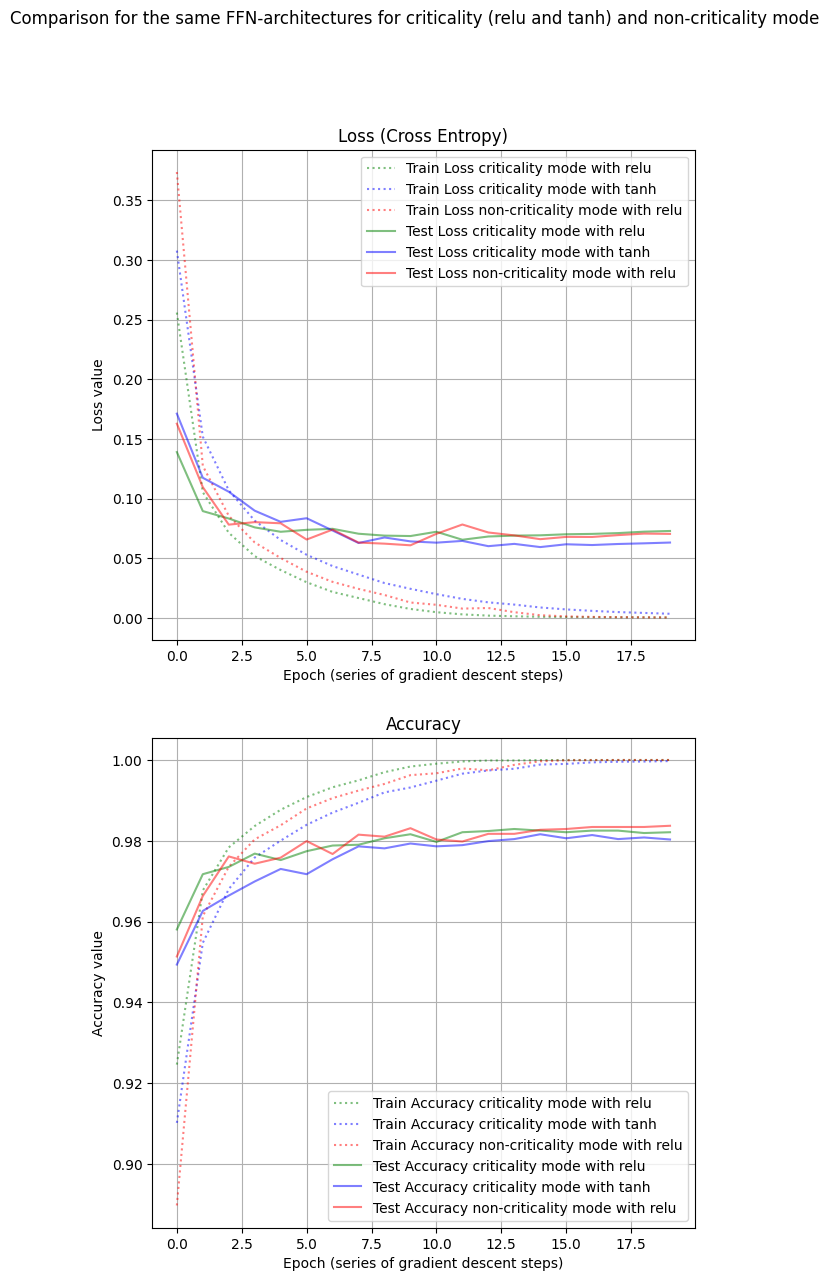

In [76]:
display.clear_output()
fig, axes = plt.subplots(2, 1, figsize=(7, 14))
axes[0].set_title('Loss (Cross Entropy)')
axes[0].plot(HISTORY_CRITICALITY['train_loss'], color='g', ls='dotted', alpha=.5, label='Train Loss criticality mode with relu')
axes[0].plot(HISTORY_CRITICALITY_TANH['train_loss'], color='b', ls='dotted', alpha=.5, label='Train Loss criticality mode with tanh')
axes[0].plot(HISTORY_NONCRITICALITY['train_loss'], color='r', ls='dotted', alpha=.5, label='Train Loss non-criticality mode with relu')
axes[0].plot(HISTORY_CRITICALITY['test_loss'], color='g', alpha=.5, label='Test Loss criticality mode with relu')
axes[0].plot(HISTORY_CRITICALITY_TANH['test_loss'], color='b', alpha=.5, label='Test Loss criticality mode with tanh')
axes[0].plot(HISTORY_NONCRITICALITY['test_loss'], color='r', alpha=.5, label='Test Loss non-criticality mode with relu')
axes[0].grid()
axes[0].legend() #(fontsize=20)
axes[0].set_xlabel("Epoch (series of gradient descent steps)")
axes[0].set_ylabel("Loss value")

axes[1].set_title('Accuracy')
axes[1].plot(HISTORY_CRITICALITY['train_accuracy'], color='g', alpha=.5, ls='dotted', label='Train Accuracy criticality mode with relu')
axes[1].plot(HISTORY_CRITICALITY_TANH['train_accuracy'], color='b', alpha=.5, ls='dotted', label='Train Accuracy criticality mode with tanh')
axes[1].plot(HISTORY_NONCRITICALITY['train_accuracy'], color='r', alpha=.5, ls='dotted', label='Train Accuracy non-criticality mode with relu')
axes[1].plot(HISTORY_CRITICALITY['test_accuracy'], color='g', alpha=.5, label='Test Accuracy criticality mode with relu')
axes[1].plot(HISTORY_CRITICALITY_TANH['test_accuracy'], color='b', alpha=.5, label='Test Accuracy criticality mode with tanh')
axes[1].plot(HISTORY_NONCRITICALITY['test_accuracy'], color='r', alpha=.5, label='Test Accuracy non-criticality mode with relu')
axes[1].grid()
axes[1].legend() #(fontsize=20)
axes[1].set_xlabel("Epoch (series of gradient descent steps)")
axes[1].set_ylabel("Accuracy value")

#fig.tight_layout()
#fig.subplots_adjust(top=0.95)
dummy=fig.suptitle("Comparison for the same FFN-architectures for criticality (relu and tanh) and non-criticality mode")

plt.show()